# Chord Visualization
In this notebook, we extract main melody from audio representation of music and experiment with spectrogram and visualization of other styles inspired by Superatism.

## 1. Experiment with triangulation

### 1.1 Dog picture demo

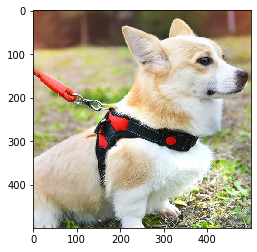

In [1]:
import numpy as np
import matplotlib.pylab as plt
from scipy.spatial import Delaunay

%matplotlib inline

im = plt.imread("test.jpg")
plt.imshow(im)

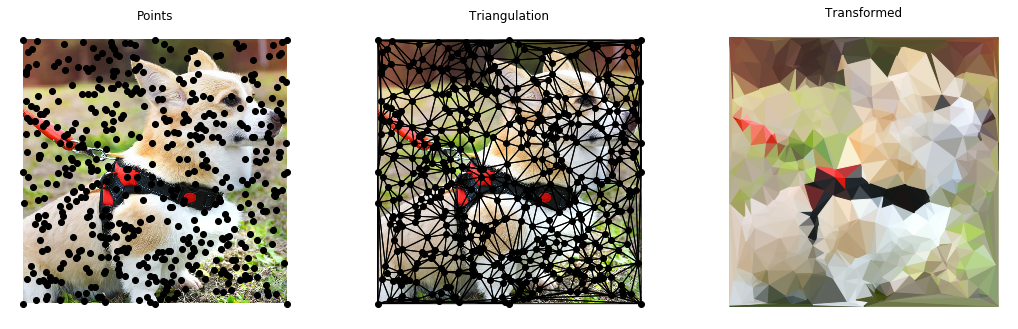

In [3]:
from triangulared import *

points = generate_uniform_random_points(im, n_points=500)
tri = Delaunay(points)

fig, axs = plt.subplots(ncols=3, figsize=(18,8), sharey=True)

ax = axs[0]
draw_image(ax, im)
draw_points(ax, points)
ax.set_title("Points")
set_axis_defaults(ax)


ax = axs[1]
draw_image(ax, im)
draw_points(ax, points)
draw_triangles(ax, tri.points, tri.vertices)
ax.set_title("Triangulation")
set_axis_defaults(ax)


ax = axs[2]
triangle_colours = get_triangle_colour(tri, im)
draw_triangles(ax, tri.points, tri.vertices, triangle_colours)
ax.set_title("Transformed")
set_axis_defaults(ax)

### 1.2 Byte visualization demo

In [4]:
file_name = "../../FMP_1/data/C1/FMP_C1_F10_Beethoven_Fifth-MM1-20_Karajan1946.wav"

file = open(file_name, 'rb')
content = file.read()
data = content[46:]

ls = [int.from_bytes(data[i:i+2], "little", signed="true") for i in range(0, len(data), 2)]
print(ls[:100])

[43, 48, 41, 35, 33, 39, 37, 29, 35, 30, 17, 26, 24, 25, 17, 17, 27, 27, 34, 21, 27, 20, 7, 22, 11, 2, -3, 0, 1, -4, -4, -5, -4, -5, 0, 8, 3, -8, -1, -6, -11, -2, -4, 11, 5, 4, 3, -12, 3, 8, 16, 19, 6, 17, 21, 25, 29, 27, 38, 29, 18, 18, 25, 30, 27, 32, 30, 26, 26, 29, 31, 18, 18, 23, 19, 18, 20, 21, 26, 22, 29, 28, 25, 39, 34, 29, 25, 18, 28, 34, 26, 14, 15, 21, 23, 32, 43, 42, 41, 24]


In [5]:
def data_to_hsl(x):
    hue = abs(x)*10 % 360
    
    return hue

2916


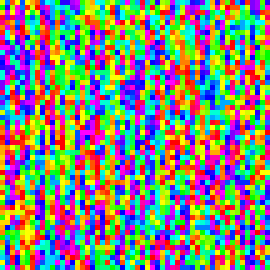

In [6]:
from PIL import Image, ImageDraw
from IPython.display import display

canvas_w, canvas_h = 270,270
square_n = 54
unit_w = 5

# color_arr = [(255,0,0),(0,0,0)] * 50
color_arr = [data_to_hsl(x) for x in ls[:square_n*square_n]]
print(len(color_arr))

img = Image.new("RGB",(canvas_w,canvas_h))

for i in range(square_n):
    for j in range(square_n):
        img1 = ImageDraw.Draw(img)
        coor = [(i*unit_w, j*unit_w), (i*unit_w+unit_w, j*unit_w+unit_w)]
        
        index = i * square_n + j
        color = "hsl({},{}%,{}%)".format(color_arr[index],100,50)
        
        img1.rectangle(coor, fill = color)  

display(img)

img.save("test2.jpg")

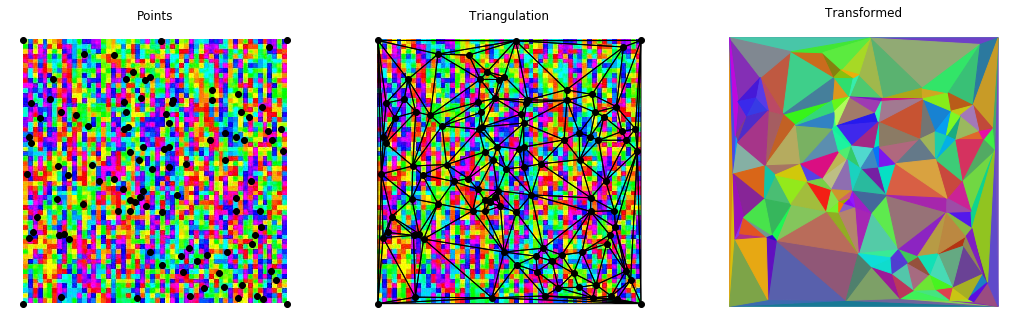

In [7]:
img = plt.imread("test2.jpg")

points = generate_uniform_random_points(img, n_points=100)
tri = Delaunay(points)

fig, axs = plt.subplots(ncols=3, figsize=(18,8), sharey=True)

ax = axs[0]
draw_image(ax, img)
draw_points(ax, points)
ax.set_title("Points")
set_axis_defaults(ax)


ax = axs[1]
draw_image(ax, img)
draw_points(ax, points)
draw_triangles(ax, tri.points, tri.vertices)
ax.set_title("Triangulation")
set_axis_defaults(ax)


ax = axs[2]
triangle_colours = get_triangle_colour(tri, img)
draw_triangles(ax, tri.points, tri.vertices, triangle_colours)
ax.set_title("Transformed")
set_axis_defaults(ax)

## 2. Extract chords from music

To extract the note events from the midi file, we use mido objects. 

We can first explore the track information in the file and see what the first 20 midi messages look like. Notice if there are all note_on events, it's because some note_on events have 0 velocity. That is equivalent to note_off event.

In [3]:
import mido

mid = mido.MidiFile(midi_file_name, clip=True)
mid.tracks

[<midi track '' 7 messages>, <midi track '' 1111 messages>]

In [4]:
for m in mid.tracks[1][:20]:
    print(m)

program_change channel=0 program=1 time=0
control_change channel=0 control=121 value=0 time=0
control_change channel=0 control=64 value=0 time=0
control_change channel=0 control=91 value=48 time=0
control_change channel=0 control=10 value=64 time=0
control_change channel=0 control=7 value=100 time=0
note_on channel=0 note=62 velocity=98 time=0
note_on channel=0 note=67 velocity=104 time=1440
note_off channel=0 note=62 velocity=0 time=26
note_off channel=0 note=67 velocity=0 time=428
note_on channel=0 note=70 velocity=105 time=26
note_on channel=0 note=67 velocity=101 time=1440
note_off channel=0 note=70 velocity=0 time=26
note_off channel=0 note=67 velocity=0 time=428
note_on channel=0 note=66 velocity=97 time=26
note_on channel=0 note=67 velocity=98 time=1440
note_off channel=0 note=66 velocity=0 time=26
note_on channel=0 note=69 velocity=101 time=214
note_off channel=0 note=67 velocity=0 time=4
note_off channel=0 note=69 velocity=0 time=221


Here we collect information about each note (start_time, end_time, pitch, velocity) from note_on and note_off event and store them in a dataframe. Also, we convert the time unit from ticks to seconds.

In [5]:
import pandas as pd

note_arr = []
time = 0
temp = {}

for m in mid.tracks[1]:
    time += m.time
    
    if m.type == "note_on" and m.velocity > 0:
        note = {"note":m.note, "time":[time,-1], "velocity":m.velocity}
        note = [time, -1, m.note, m.velocity]
        temp[m.note] = note
        
    elif m.type == "note_off" or (m.type == "note_on" and m.velocity == 0):
        note = temp[m.note]
        note[1] = time
        note_arr.append(note)

df = pd.DataFrame(note_arr, columns=['Start', 'End', 'Pitch', 'Velocity'])

# convert from time units from ticks to seconds
tempo = 500000 # default tempo = 500000 ms/beat
ticks_per_beat = mid.ticks_per_beat
df["Start"] = tempo * df["Start"] / ticks_per_beat / 1000000
df["End"] = tempo * df["End"] / ticks_per_beat / 1000000

df

Start         End  Pitch  Velocity
0      0.00    0.763542     62        98
1      0.75    0.986458     67       104
2      1.00    1.763542     70       105
3      1.75    1.986458     67       101
4      2.00    2.763542     66        97
..      ...         ...    ...       ...
547  140.50  140.750000     78       111
548  141.00  141.500000     55       114
549  141.00  141.500000     62       114
550  141.00  141.500000     70       114
551  141.00  141.500000     79       114

[552 rows x 4 columns]

## 2. Convert note events to color and shape

To visualize our notes, we need to convert the note events to the color of the rectangle in HSL values and the coordinates of rectangles on the canvas.

Here's how we map our note value to hsl value for visualization.
* pitch_class (1-12) => hue (0-359)
* octave (0-8) => lightness (20-80)
* velocity (40-127) => saturation (0-100)

In [6]:
def note_to_hsl(note):
    pitch = note[2]
    velocity = note[3]
    
    octave = pitch // 12 - 1
    pitch_class = pitch % 12
    
    hue = int(pitch_class * 30)
    lightness = int(octave / 8 * 60 + 20)
    saturation = int((velocity-20) / 67 * 100)
    
    hsl = (hue,saturation,lightness)
    
    return hsl

note = list(df.iloc[0])
hsl = note_to_hsl(note)
print(hsl)

(60, 116, 50)


We map the note event to the coordinates of rectangle according to time.

In [7]:
def note_to_coor(note, canvas, note_w):
    # note_w is the length in seconds each row displays
    w = canvas[0]
    unit_h = 25
    
    x0 = (note[0] % note_w) / note_w * w
    x1 = (note[1] % note_w) / note_w * w
    y0 = note[0] // note_w * unit_h * 2
    y1 = y0 + unit_h
    
    if x0 > x1:
        x1 = w
    coor = [x0,y0,x1,y1]
    
    return coor

We can also implement a helper function to convert from midi pitch number to note name (ex. from 60 to C4).

In [8]:
def pitch_to_name(pitch):
    octave = pitch // 12 - 1
    pitch_class = pitch % 12
    
    pitch_classes = ["C","C#","D","D#","E","F","F#","G","G#","A","A#","B"]
    name = str(pitch_classes[pitch_class]) + str(octave)
    
    return name

print(pitch_to_name(62))

D4


## 3. Display visualization

To test how good the color we picked for each note pitch, we can visualize a test note dataframe of chromatic scale from A0 to C8.

[(270, 119, 20), (300, 119, 20), (330, 119, 20), (0, 119, 27), (30, 119, 27), (60, 119, 27), (90, 119, 27), (120, 119, 27), (150, 119, 27), (180, 119, 27), (210, 119, 27), (240, 119, 27), (270, 119, 27), (300, 119, 27), (330, 119, 27), (0, 119, 35), (30, 119, 35), (60, 119, 35), (90, 119, 35), (120, 119, 35), (150, 119, 35), (180, 119, 35), (210, 119, 35), (240, 119, 35), (270, 119, 35), (300, 119, 35), (330, 119, 35), (0, 119, 42), (30, 119, 42), (60, 119, 42), (90, 119, 42), (120, 119, 42), (150, 119, 42), (180, 119, 42), (210, 119, 42), (240, 119, 42), (270, 119, 42), (300, 119, 42), (330, 119, 42), (0, 119, 50), (30, 119, 50), (60, 119, 50), (90, 119, 50), (120, 119, 50), (150, 119, 50), (180, 119, 50), (210, 119, 50), (240, 119, 50), (270, 119, 50), (300, 119, 50)]


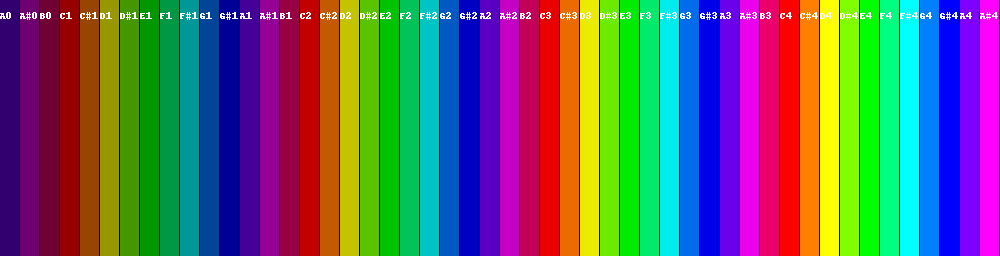

In [9]:
from PIL import Image, ImageDraw
from IPython.display import display

# A test note dataframe as chromatic scale from A0 to C8
note_df = pd.DataFrame(columns=['Start', 'End', 'Pitch', 'Velocity'])
note_df["Pitch"] = range(21,71)
note_df["Velocity"] = 100

hsl_ls = [note_to_hsl(list(note_df.iloc[i])) for i in range(len(note_df))]
print(hsl_ls)
w, h = 1000, 256
img = Image.new("RGB", (w, h)) 
x0, y0, x1, y1 = 0, 0, 18, 256

for i in range(len(hsl_ls)):
    img1 = ImageDraw.Draw(img)
    coor = [(x0, y0), (x1, y1)]
    
    color = "hsl({},{}%,{}%)".format(hsl_ls[i][0],hsl_ls[i][1],hsl_ls[i][2])
    img1.rectangle(coor, fill = color)
    
    note_num = note_df["Pitch"].iloc[i]
    note_name = pitch_to_name(note_num)
    
    img1.text((x0,y0+10),note_name,fill="white")
    
    x0 = x0 + 20
    x1 = x1 + 20

display(img)

Now we can visualize the actual music.

In [10]:
# Changes made to note event time for better visualization effect
df.loc[df["Start"] >= 92,"Start"] += 4
df.loc[df["Start"] >= 92,"End"] += 4

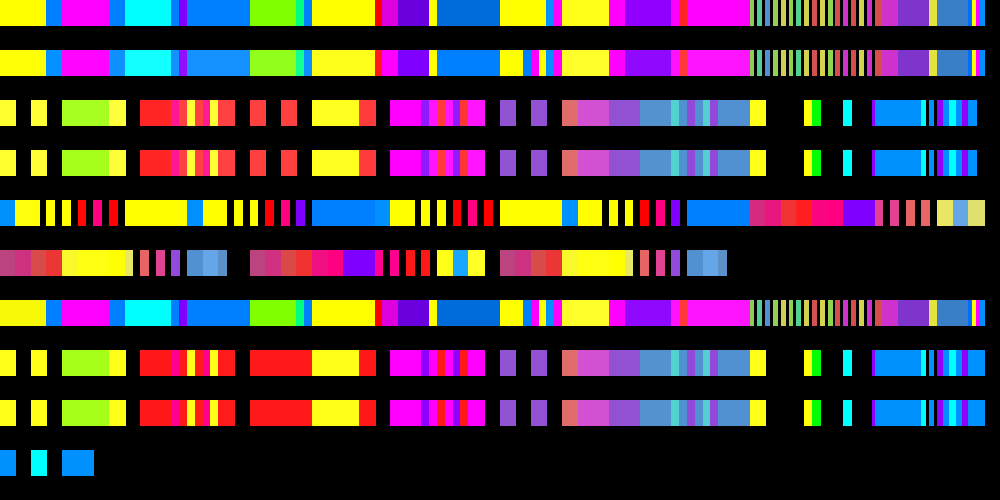

In [12]:
hsl_ls = [note_to_hsl(list(df.iloc[i])) for i in range(len(df))]

w, h = 1000, 500
img = Image.new("RGB", (w, h)) 
x0, y0, x1, y1 = 0, 0, 50, 25

for i in range(len(df)):
    x0, y0, x1, y1 = note_to_coor(df.iloc[i],[w,h],16)
    
    img1 = ImageDraw.Draw(img)
    coor = [(x0, y0), (x1, y1)]
    
    color = "hsl({},{}%,{}%)".format(hsl_ls[i][0],hsl_ls[i][1],hsl_ls[i][2])
    img1.rectangle(coor, fill = color)
    
    note_num = df["Pitch"].iloc[i]
    note_name = pitch_to_name(note_num)
    
#     img1.text((x0,y0+10),note_name,fill="white")
    
display(img)

## 4. Overlapping commands

In [31]:
midi_file_name2 = "../../../ML/data_set/maestro-v3.0.0/2004/MIDI-Unprocessed_SMF_22_R1_2004_01-04_ORIG_MID--AUDIO_22_R1_2004_05_Track05_wav.midi"

Fs = 22050
midi_data = pretty_midi.PrettyMIDI(midi_file_name2)
audio_data = midi_data.synthesize(fs=Fs)
ipd.Audio(audio_data, rate=Fs)

In [32]:
note_arr = []
time = 0
temp = {}

mid = mido.MidiFile(midi_file_name2, clip=True)

for m in mid.tracks[1]:
    time += m.time
    
    if m.type == "note_on" and m.velocity > 0:
        note = {"note":m.note, "time":[time,-1], "velocity":m.velocity}
        note = [time, -1, m.note, m.velocity]
        temp[m.note] = note
        
    elif m.type == "note_off" or (m.type == "note_on" and m.velocity == 0):
        note = temp[m.note]
        note[1] = time
        note_arr.append(note)

df = pd.DataFrame(note_arr, columns=['Start', 'End', 'Pitch', 'Velocity'])

# convert from time units from ticks to seconds
tempo = 500000 # default tempo = 500000 ms/beat
ticks_per_beat = mid.ticks_per_beat
df["Start"] = tempo * df["Start"] / ticks_per_beat / 1000000
df["End"] = tempo * df["End"] / ticks_per_beat / 1000000

df

Start         End  Pitch  Velocity
0       0.091667    0.123958     74        49
1       0.204167    0.245833     79        73
2       0.337500    0.378125     83        58
3       0.455208    0.491667     78        62
4       0.580208    0.633333     79        69
...          ...         ...    ...       ...
1618  128.631250  130.526042     59        87
1619  128.443750  130.548958     62        90
1620  128.268750  130.550000     67        89
1621  128.925000  130.562500     55        90
1622  128.259375  130.581250     43        84

[1623 rows x 4 columns]

In [33]:
start_pt = 0
end_pt = 0
overlap = {}

for i in range(len(df)):
    if start_pt < end_pt:
        overlap[[start_pt,min(end_pt)]] = df["Pitch"].iloc[i]
        start_pt = df.iloc[i]

In [34]:
df[df["Start"]>10.942][:20]
# df.iloc[147]

Start        End  Pitch  Velocity
116  10.947917  10.978125     67        74
117  10.942708  10.984375     74        71
118  11.078125  11.119792     71        68
119  11.220833  11.256250     62        74
120  11.213542  11.256250     71        72
121  11.351042  11.387500     64        77
122  11.348958  11.393750     67        73
123  11.479167  11.510417     60        80
124  11.482292  11.527083     72        64
125  11.609375  11.643750     55        69
126  11.607292  11.646875     76        67
127  11.744792  11.893750     67        85
128  11.763542  11.961458     76        68
129  11.902083  11.972917     72        66
130  12.047917  12.083333     67        47
131  12.045833  12.085417     60        72
132  12.163542  12.213542     67        77
133  12.172917  12.215625     62        78
134  12.286458  12.340625     59        81
135  12.295833  12.340625     71        68

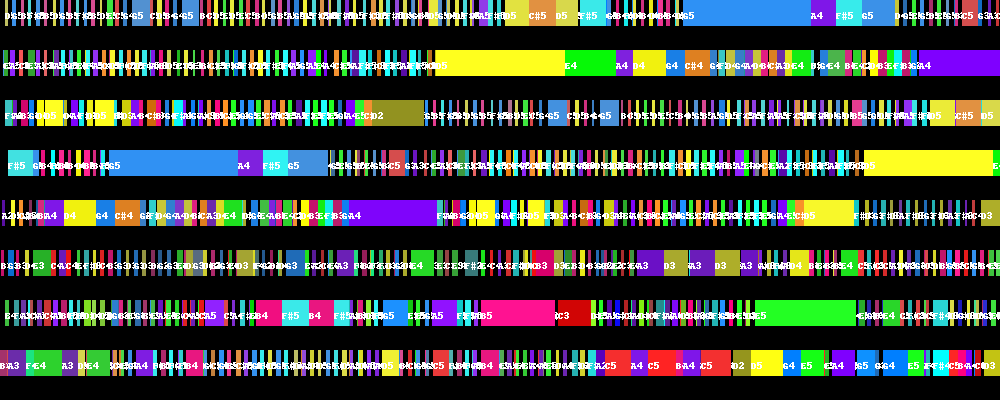

In [35]:
hsl_ls = [note_to_hsl(list(df.iloc[i])) for i in range(len(df))]

w, h = 1000, 400
img = Image.new("RGB", (w, h)) 
x0, y0, x1, y1 = 0, 0, 50, 25

for i in range(len(df)):
    x0, y0, x1, y1 = note_to_coor(df.iloc[i],[w,h])
    
    img1 = ImageDraw.Draw(img)
    coor = [(x0, y0), (x1, y1)]
    
    color = "hsl({},{}%,{}%)".format(hsl_ls[i][0],hsl_ls[i][1],hsl_ls[i][2])
    img1.rectangle(coor, fill = color)
    
    note_num = df["Pitch"].iloc[i]
    note_name = pitch_to_name(note_num)
    
    img1.text((x0,y0+10),note_name,fill="white")
    
display(img)